# Imports

In [34]:
# scikit-learn pereptron and adaline implementations
from sklearn.linear_model import Perceptron as SklearnPerceptron
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

# Additional packages
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split  # <- add if needed


# Part 1: Preprocessing

## Project Adult Cleaning

In [35]:
# Load the provided dataset
adult_df = pd.read_csv("/content/project_adult.csv")

# Quick look at the data
print(adult_df.shape)
adult_df.head()

(26048, 16)


,Unnamed: 0,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,5514,33,Local-gov,198183,Bachelors,13,Never-married,Prof-specialty,Not-in-family,White,Female,0,0,50,United-States,>50K
1,19777,36,Private,86459,Assoc-voc,11,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,1887,50,United-States,>50K
2,10781,58,Self-emp-not-inc,203039,9th,5,Separated,Craft-repair,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,32240,21,Private,180190,Assoc-voc,11,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,46,United-States,<=50K
4,9876,27,Private,279872,Some-college,10,Divorced,Other-service,Not-in-family,White,Male,0,0,40,United-States,<=50K


### Step a: Handle Missing Values

In [36]:
# Replace "?" with NaN for consistency
adult_df = adult_df.replace("?", pd.NA)

# Drop rows with missing values (common approach for Adult dataset)
adult_df = adult_df.dropna()

print("After dropping missing values:", adult_df.shape)


After dropping missing values: (24157, 16)


### Step b: Encode categorical values

In [37]:
# Separate features and target
X = adult_df.drop("income", axis=1)   # predictors
y = adult_df["income"]                # response

# One-hot encode categorical columns
X_encoded = pd.get_dummies(X, drop_first=True)

print("Encoded feature shape:", X_encoded.shape)


Encoded feature shape: (24157, 97)


### Split into train and test

In [38]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.3, random_state=42, stratify=y
)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)


Training set size: (16909, 97)
Test set size: (7248, 97)


### Step c: Standardize numerical values

In [39]:
scaler = StandardScaler()

# Fit on training set, transform both train and test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Standardization complete.")


Standardization complete.


I also decided to drop that unnamed column, which is some sort of ID column.

In [40]:
adult_df = adult_df.drop(columns=["Unnamed: 0"])

## Project Validation Inputs Cleaning

In [41]:
# Load the validation inputs dataset
val_df = pd.read_csv("/content/project_validation_inputs.csv")

# Drop the unnamed ID column
val_df = val_df.drop(columns=["Unnamed: 0"])

print(val_df.shape)
val_df.head()

(6513, 14)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,27,Private,160178,Some-college,10,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,38,United-States
1,45,State-gov,50567,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States
2,29,Private,185908,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,Black,Male,0,0,55,United-States
3,30,Private,190040,Bachelors,13,Never-married,Machine-op-inspct,Not-in-family,White,Female,0,0,40,United-States
4,29,Self-emp-not-inc,189346,Some-college,10,Divorced,Craft-repair,Not-in-family,White,Male,2202,0,50,United-States


### Step a: Handle Missing Values

In [42]:
# Replace "?" with NaN
val_df = val_df.replace("?", pd.NA)

# Drop rows with missing values (same as training data handling)
val_df = val_df.dropna()

print("After dropping missing values:", val_df.shape)


After dropping missing values: (6005, 14)


### Step b: Encode Categorical values

In [43]:
# One-hot encode the validation features
val_encoded = pd.get_dummies(val_df, drop_first=True)

print("Encoded validation shape:", val_encoded.shape)


Encoded validation shape: (6005, 94)


In [44]:
# Align encoded validation data with training columns
# This ensures both have the same one-hot encoded feature set
val_encoded = val_encoded.reindex(columns=X_encoded.columns, fill_value=0)

print("Aligned validation shape:", val_encoded.shape)


Aligned validation shape: (6005, 97)


### Step c: Standardize numerical values

In [45]:
# Apply the same scaler fit on training data
val_scaled = scaler.transform(val_encoded)

print("Validation data preprocessing complete. Ready for predictions later.")


Validation data preprocessing complete. Ready for predictions later.


In [46]:
print("=== Preprocessing Summary ===")
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_test_scaled  shape: {X_test_scaled.shape}")
print(f"Validation (val_scaled) shape: {val_scaled.shape}")

print("\nTarget variable sizes:")
print(f"y_train shape: {y_train.shape}")
print(f"y_test  shape: {y_test.shape}")

# Double-check column consistency between training/test/validation
train_cols = X_encoded.columns
val_cols   = val_encoded.columns

print("\nColumn alignment check:")
print("Validation columns match training?", set(train_cols) == set(val_cols))


=== Preprocessing Summary ===
X_train_scaled shape: (16909, 97)
X_test_scaled  shape: (7248, 97)
Validation (val_scaled) shape: (6005, 97)

Target variable sizes:
y_train shape: (16909,)
y_test  shape: (7248,)

Column alignment check:
Validation columns match training? True


# Part 2: Implementing Perceptron and Adaline

In [47]:
# --- Use scaled features for gradient-based learning ---
Xtr = X_train_scaled
Xte = X_test_scaled

# --- Map labels to {-1, +1} for our custom implementations ---
# Original labels are strings like '<=50K' and '>50K'
def y_to_pm1(y_series):
    return np.where(y_series.values == '>50K', 1, -1)

def pm1_to_str(y_pm1):
    return np.where(y_pm1 == 1, '>50K', '<=50K')

ytr_pm1 = y_to_pm1(y_train)
yte_pm1 = y_to_pm1(y_test)

# --- Custom Perceptron (Raschka style) ---
class PerceptronGD:
    def __init__(self, eta=0.1, n_iter=30, random_state=42):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
        self.errors_ = []  # misclassifications per epoch

    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        self.b_ = 0.0
        self.errors_ = []
        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                if update != 0.0:
                    self.w_ += update * xi
                    self.b_ += update
                    errors += 1
            self.errors_.append(errors)
        return self

    def net_input(self, X):
        return np.dot(X, self.w_) + self.b_

    def predict(self, X):
        z = self.net_input(X)
        return np.where(z >= 0.0, 1, -1)

# --- Custom AdalineSGD (stochastic gradient descent on SSE) ---
class AdalineSGD:
    def __init__(self, eta=1e-4, n_iter=30, shuffle=True, random_state=42):
        self.eta = eta
        self.n_iter = n_iter
        self.shuffle = shuffle
        self.random_state = random_state
        self.loss_ = []  # MSE per epoch

    def _shuffle(self, X, y):
        r = self._rgen.permutation(len(y))
        return X[r], y[r]

    def _update(self, xi, target):
        # Linear activation (no step); gradient from SSE
        output = np.dot(xi, self.w_) + self.b_
        error = target - output
        self.w_ += self.eta * xi * error
        self.b_ += self.eta * error
        return 0.5 * (error ** 2)

    def fit(self, X, y):
        self._rgen = np.random.RandomState(self.random_state)
        self.w_ = self._rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        self.b_ = 0.0
        self.loss_ = []
        for _ in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            # accumulate loss over the epoch
            losses = [self._update(xi, target) for xi, target in zip(X, y)]
            self.loss_.append(np.mean(losses))
        return self

    def predict(self, X):
        z = np.dot(X, self.w_) + self.b_
        return np.where(z >= 0.0, 1, -1)

# --- Train both on the scaled data ---
ppn = PerceptronGD(eta=0.1, n_iter=30, random_state=42).fit(Xtr, ytr_pm1)
ada = AdalineSGD(eta=1e-4, n_iter=30, random_state=42).fit(Xtr, ytr_pm1)


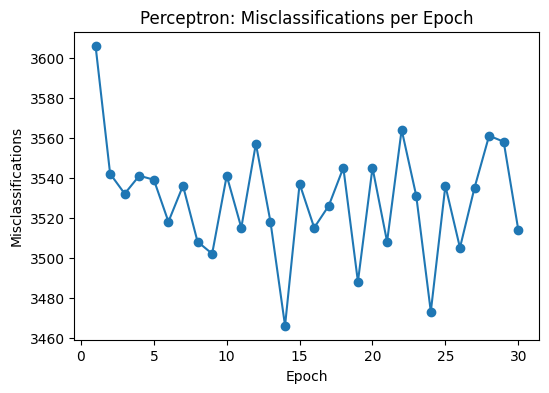

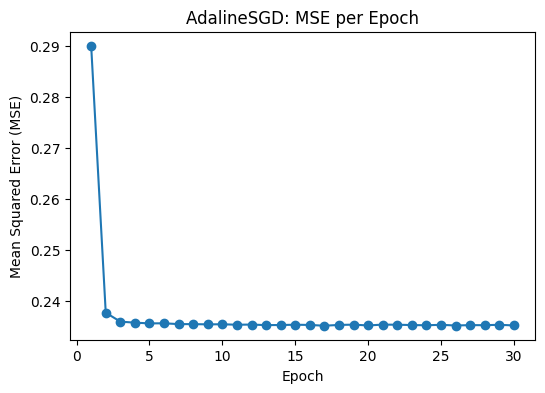

In [48]:
# === Part 2(b): Plot training curves ===
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Misclassifications')
plt.title('Perceptron: Misclassifications per Epoch')
plt.show()

plt.figure(figsize=(6,4))
plt.plot(range(1, len(ada.loss_) + 1), ada.loss_, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('AdalineSGD: MSE per Epoch')
plt.show()


In [49]:
# === Part 2(c): Evaluate accuracy on test set (custom models) ===
from sklearn.metrics import accuracy_score

yte_pred_ppn_pm1 = ppn.predict(Xte)
yte_pred_ada_pm1 = ada.predict(Xte)

acc_ppn = accuracy_score(yte_pm1, yte_pred_ppn_pm1)
acc_ada = accuracy_score(yte_pm1, yte_pred_ada_pm1)

print(f"Custom Perceptron accuracy: {acc_ppn:.4f}")
print(f"Custom AdalineSGD accuracy: {acc_ada:.4f}")


Custom Perceptron accuracy: 0.7918
Custom AdalineSGD accuracy: 0.8368


In [50]:
# === Part 2(d): Predict on validation inputs using the best CUSTOM model ===
# Choose the better one based on test accuracy
best_is_ppn = acc_ppn >= acc_ada

if best_is_ppn:
    val_pred_pm1 = ppn.predict(val_scaled)
    best_name = "Custom Perceptron"
else:
    val_pred_pm1 = ada.predict(val_scaled)
    best_name = "Custom AdalineSGD"

val_pred_labels_custom = pm1_to_str(val_pred_pm1)

print(f"Best custom model: {best_name}")
print("Validation predictions (first 10):", val_pred_labels_custom[:10])
# (We will save required CSVs in 2(e) using scikit-learn models, per project instructions.)


Best custom model: Custom AdalineSGD
Validation predictions (first 10): ['<=50K' '<=50K' '>50K' '<=50K' '<=50K' '>50K' '>50K' '<=50K' '<=50K'
 '<=50K']


### Step e:

In [51]:
# 1) ensure the block uses the scaled features
X_train = X_train_scaled
X_test  = X_test_scaled

# 2) increase max_iter (minor tweak)
sk_ppn = SklearnPerceptron(eta0=0.1, max_iter=1000, random_state=42)
sk_ppn.fit(X_train, y_train)
sk_y_pred_ppn = sk_ppn.predict(X_test)
print(f"Scikit-learn Perceptron accuracy: {accuracy_score(y_test, sk_y_pred_ppn):.4f}")

# Instructor's proxy for "Adaline" using SGDClassifier with perceptron loss
sk_ada = SGDClassifier(loss='perceptron', eta0=0.0001, learning_rate='constant', max_iter=1000, random_state=42)
sk_ada.fit(X_train, y_train)
sk_y_pred_ada = sk_ada.predict(X_test)
print(f"Scikit-learn Adaline (SGDClassifier) accuracy: {accuracy_score(y_test, sk_y_pred_ada):.4f}")

# === Save required validation predictions for Part 2 (scikit-learn models) ===
# Per the project deliverables, the four CSVs must be from scikit-learn models.
# Here we produce the two for Part 2; Logistic Regression and SVM will be saved in Part 3.
GROUP_NUM = "13"  # <- replace with your group number

perceptron_val_preds = sk_ppn.predict(val_scaled)
adaline_val_preds    = sk_ada.predict(val_scaled)

pd.DataFrame({'income': perceptron_val_preds}).to_csv(f'Group_{GROUP_NUM}_Perceptron_PredictedOutputs.csv', index=False)
pd.DataFrame({'income': adaline_val_preds}).to_csv(f'Group_{GROUP_NUM}_Adaline_PredictedOutputs.csv', index=False)

print("Saved:",
      f"Group_{GROUP_NUM}_Perceptron_PredictedOutputs.csv and Group_{GROUP_NUM}_Adaline_PredictedOutputs.csv")

Scikit-learn Perceptron accuracy: 0.7752
Scikit-learn Adaline (SGDClassifier) accuracy: 0.7805
Saved: Group_13_Perceptron_PredictedOutputs.csv and Group_13_Adaline_PredictedOutputs.csv


# Part 3: Implement Logistic Regression and SVM

In [52]:
# === Part 3(a): Train Logistic Regression and SVM (scikit-learn) ===
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
import numpy as np

# We'll do a tiny sweep over C to pick the best on the test split (simple & in-class style)
C_list = [0.01, 0.1, 1.0, 10.0, 100.0]

best_lr, best_lr_acc, best_lr_C = None, -1.0, None
best_svm, best_svm_acc, best_svm_C = None, -1.0, None

print("Logistic Regression C-sweep:")
for C in C_list:
    lr = LogisticRegression(C=C, penalty='l2', solver='lbfgs', max_iter=200, random_state=42)
    lr.fit(X_train_scaled, y_train)
    acc = accuracy_score(y_test, lr.predict(X_test_scaled))
    print(f"  C={C:<6}  acc={acc:.4f}")
    if acc > best_lr_acc:
        best_lr, best_lr_acc, best_lr_C = lr, acc, C

print("\nLinear SVM (LinearSVC) C-sweep:")
for C in C_list:
    svm = LinearSVC(C=C, max_iter=5000, random_state=42)
    svm.fit(X_train_scaled, y_train)
    acc = accuracy_score(y_test, svm.predict(X_test_scaled))
    print(f"  C={C:<6}  acc={acc:.4f}")
    if acc > best_svm_acc:
        best_svm, best_svm_acc, best_svm_C = svm, acc, C

print("\nBest models selected:")
print(f"  Logistic Regression: C={best_lr_C}  test acc={best_lr_acc:.4f}")
print(f"  Linear SVM:          C={best_svm_C}  test acc={best_svm_acc:.4f}")


Logistic Regression C-sweep:
  C=0.01    acc=0.8422
  C=0.1     acc=0.8448
  C=1.0     acc=0.8453
  C=10.0    acc=0.8455
  C=100.0   acc=0.8455

Linear SVM (LinearSVC) C-sweep:
  C=0.01    acc=0.8453
  C=0.1     acc=0.8455
  C=1.0     acc=0.8455
  C=10.0    acc=0.8455
  C=100.0   acc=0.8455

Best models selected:
  Logistic Regression: C=10.0  test acc=0.8455
  Linear SVM:          C=0.1  test acc=0.8455


In [53]:
# === Part 3(b): Report best accuracies (summary) ===
print(f"Best Logistic Regression accuracy: {best_lr_acc:.4f} (C={best_lr_C})")
print(f"Best Linear SVM accuracy:          {best_svm_acc:.4f} (C={best_svm_C})")


Best Logistic Regression accuracy: 0.8455 (C=10.0)
Best Linear SVM accuracy:          0.8455 (C=0.1)


In [54]:
# === Part 3(c): Predict on validation inputs and save CSVs (scikit-learn) ===
import pandas as pd

GROUP_NUM = "13"   # <-- REPLACE with your actual group number

val_pred_lr  = best_lr.predict(val_scaled)
val_pred_svm = best_svm.predict(val_scaled)

pd.DataFrame({'income': val_pred_lr}).to_csv(f'Group_{GROUP_NUM}_LogisticRegression_PredictedOutputs.csv', index=False)
pd.DataFrame({'income': val_pred_svm}).to_csv(f'Group_{GROUP_NUM}_SVM_PredictedOutputs.csv', index=False)

print("Saved:")
print(f"  Group_{GROUP_NUM}_LogisticRegression_PredictedOutputs.csv")
print(f"  Group_{GROUP_NUM}_SVM_PredictedOutputs.csv")


Saved:
  Group_13_LogisticRegression_PredictedOutputs.csv
  Group_13_SVM_PredictedOutputs.csv


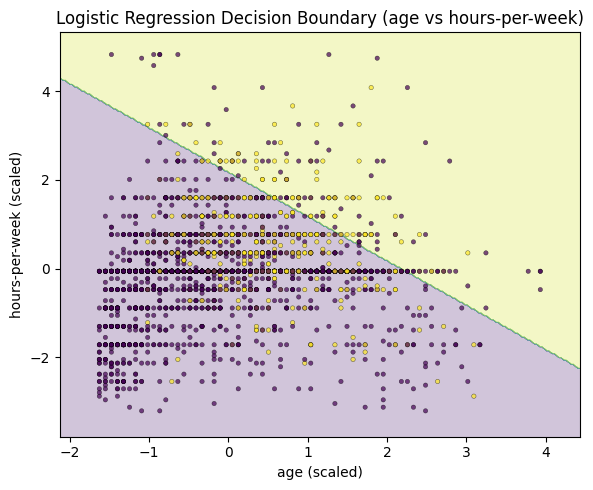

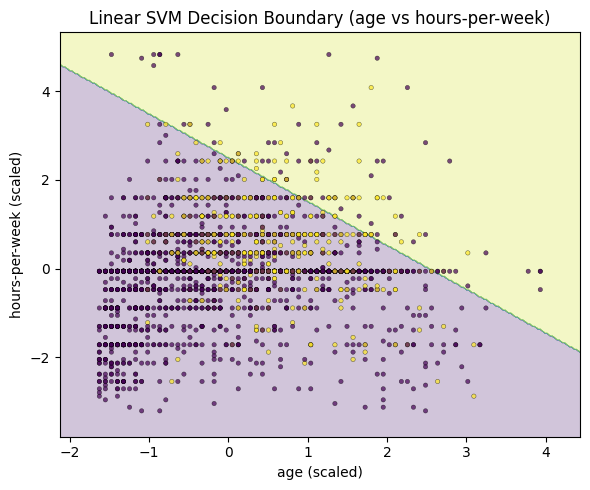

In [55]:
# === Part 3(d): Decision boundaries using 2 features (age, hours-per-week) ===
import matplotlib.pyplot as plt
import numpy as np

# We need the column order used when scaling. X_encoded.columns should exist from Part 1.
# If you renamed variables, set feature_names to your full feature list in the same order used for scaling.
feature_names = list(X_encoded.columns)

# Indices of the two numeric features in the scaled arrays:
feat_a, feat_b = 'age', 'hours-per-week'
idx_a, idx_b = feature_names.index(feat_a), feature_names.index(feat_b)

# Extract the two features from the scaled matrices
Xtr_2 = X_train_scaled[:, [idx_a, idx_b]]
Xte_2 = X_test_scaled[:,  [idx_a, idx_b]]

# Map y to {0,1} for color plotting while keeping original labels for training
y_train_bin = (y_train.values == '>50K').astype(int)
y_test_bin  = (y_test.values  == '>50K').astype(int)

# Fit LR and SVM on just these two features with the best C values found
lr_2   = LogisticRegression(C=best_lr_C, penalty='l2', solver='lbfgs', max_iter=200, random_state=42).fit(Xtr_2, y_train)
svm_2  = LinearSVC(C=best_svm_C, max_iter=5000, random_state=42).fit(Xtr_2, y_train)

def plot_decision_boundary(model, X2, ybin, title):
    # Create a grid over the 2D feature space (already scaled)
    x_min, x_max = X2[:, 0].min() - 0.5, X2[:, 0].max() + 0.5
    y_min, y_max = X2[:, 1].min() - 0.5, X2[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]
    # Use decision_function if available; else predict
    if hasattr(model, "decision_function"):
        Z = model.decision_function(grid)
        Z = (Z > 0).astype(int)
    else:
        Z = model.predict(grid)
        Z = (Z == '>50K').astype(int) if Z.dtype.kind in {'U','S','O'} else Z
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(6,5))
    plt.contourf(xx, yy, Z, alpha=0.25)
    # Scatter a subsample of training points for clarity
    n_plot = min(3000, X2.shape[0])
    idx = np.random.RandomState(42).choice(X2.shape[0], n_plot, replace=False)
    plt.scatter(X2[idx, 0], X2[idx, 1], c=ybin[idx], s=10, edgecolor='k', linewidth=0.3, alpha=0.7)

    plt.xlabel(f'{feat_a} (scaled)')
    plt.ylabel(f'{feat_b} (scaled)')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Plot LR boundary
plot_decision_boundary(lr_2, Xtr_2, y_train_bin, f'Logistic Regression Decision Boundary ({feat_a} vs {feat_b})')

# Plot Linear SVM boundary
plot_decision_boundary(svm_2, Xtr_2, y_train_bin, f'Linear SVM Decision Boundary ({feat_a} vs {feat_b})')
